In [2]:
import pandas as pd
import numpy as np
import sklearn.cluster
import matplotlib.pyplot as plt

### Kmeans : Cluster Questions to Replace Tags

In [18]:
# Loading data
questions = pd.read_csv('../riiid_data/questions.csv')
questions.columns = ['content_id','bundle_id','correct_answer','part','tags']
questions = questions[['content_id', 'part', 'tags']].sort_values(by='content_id')
questions.tags = questions.tags.map(lambda x: str(x).split())

In [25]:
# prepare input data for custering
tags = []
for t in questions.tags:
    tags+=t
tags = [int(x) for x in set(tags) if x!='nan']

f = lambda x: 1/(1 + np.exp(-x))
v = np.zeros((13523, 187), dtype=np.float32)
for content,part,tag_list in questions.values:
    if tag_list[0]=='nan':
        continue

    tag_list = list(map(int, tag_list))
    for tag in range(1,188):
        if tag in tag_list:
            v[content,tag-1] = 1

kmeans = sklearn.cluster.KMeans(n_clusters=20, random_state=93)

kmeans.fit(v)

kmeans_labels = {content_id:label for content_id,label in zip(questions.content_id,kmeans.labels_)}

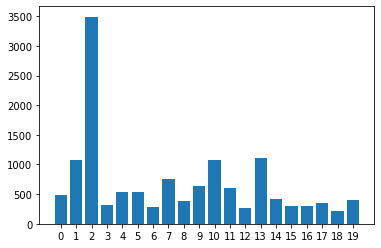

In [26]:
import collections
import matplotlib.pyplot as plt
x = collections.Counter(kmeans.labels_).keys()
y = collections.Counter(kmeans.labels_).values()
plt.xticks([i for i in range(20)])
plt.bar(x,y)
plt.show()

In [ ]:
with open('../kmeans_labels.pkl', 'wb') as f:
    pickle.dump(kmeans_labels, f)

<hr>

### Bayesian Knowledge Tracing : build input

Building input for use with the [hmm-scalable](#https://github.com/myudelson/hmm-scalable) <i>command line tool</i>. The implementation is described in the authors' [Individualized Bayesian Knowledge Tracing Models](#https://link.springer.com/chapter/10.1007/978-3-642-39112-5_18) paper.

The goal is to use the tool to create individualized <i>slip</i> and <i>guess</i> parameters for each user, tag, and/or question.

<br><br>
Example script to run command line tool:
```Bash
./trainhmm -s 1.1 -i 1000 -U g,g -m 1 -d ~ -p 1 -P 1 bkt_input.csv model.txt predict.txt
```

In [1]:
%run preprocessor.ipynb

In [11]:
df = dt.fread(f'../riiid_data/train.csv', columns={
    'timestamp':dt.int64,
    'user_id':dt.int32,
    'content_id':dt.int32,
    'content_type_id':dt.bool8,
    'answered_correctly':dt.int32})

df = df[dt.f.content_type_id==0, (dt.f.timestamp,
                                    dt.f.user_id,
                                    dt.f.content_id,
                                    dt.int8(dt.f.answered_correctly))]

df[dt.f.answered_correctly==0,dt.update(answered_correctly=2)]

df, _ = time_series_split(df, train_size=0.9, sample=1.0)
del _
gc.collect()

76

In [13]:
questions = pd.read_csv('../riiid_data/questions.csv')[['question_id', 'part', 'tags', 'bundle_id']]
questions.tags = questions.tags.map(lambda x: str(x).split())

df = df.to_pandas()
df['tags'] = df['content_id'].map({q:lst for q,lst in questions[['question_id', 'tags']].values})

In [15]:
df.head()

,timestamp,user_id,content_id,answered_correctly,tags
0,0,115,5692,1,[151]
1,56943,115,5716,1,[168]
2,118363,115,128,1,"[131, 149, 92]"
3,131167,115,7860,1,"[131, 104, 81]"
4,137965,115,7922,1,"[131, 149, 92]"


### Write input to file

In [ ]:
with open('bkt_input.csv', 'w') as f:
    for row in df.values:
        user = row[1]
        content = row[2]
        correct = row[3]
        tags = row[4]
        if len(tags) > 0 and tags[0] != '-1':
            tags = '~'.join(tags)
        else:
            tags = '.'


        f.write(f'{correct}\t{user}\t{content}\t{tags}\n')

### Reading model file 

Store the BKT model parameters in a dictionary for mapping and use within LGBM

- ps : probability of knowing a knowledge unit, but incorrectly answering the question
- pg : probability of not knowing a knowledge unit, but guessing the question corectly
- pt : probability of a student mastering the knowledge unit after practicing
- plo: probability the skill was already known

In [19]:
skills_dict = {}
last_row = None

with open('../old/bkt_model.txt', 'r') as f:
    next(f);next(f);next(f);next(f);next(f);next(f);next(f)
    
    for line in f:
        row = line[:-1].split('\t')
        if len(row) == 2:
            skills_dict[row[1]] = {'plo':None, 'pt':None, 'ps':None, 'pg':None}
            last_row = row[1]
        else:
            if row[0] == 'PI':
                skills_dict[last_row]['plo'] = row[1]
            if row[0] == 'A':
                skills_dict[last_row]['pt'] = row[3]
            if row[0] == 'B':
                skills_dict[last_row]['ps'] = row[2]
                skills_dict[last_row]['pg'] = row[3]

In [24]:
skills_dict['149']

{'plo': '0.6911548620',
 'pt': '0.5272952879',
 'ps': '0.1243009788',
 'pg': '0.3000000000'}